### Produce Maps

In [4]:
import numpy as np
import os  # For Saving to Folder
import pandas as pd
import matplotlib.pyplot as plt

import socket
import os as os
import sys as sys
import multiprocessing as mp
import matplotlib.cm as cm
import matplotlib.colors as cls
import matplotlib.colorbar as clb
from matplotlib import gridspec

# For Arial Font
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'   # Set the defaul
# Make sure to have the font installed (it is on cluster for Harald)
rcParams['font.sans-serif'] = ['Arial']

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("compute-"):
    print("HSM Computational partition detected.")
    path = "/n/groups/reich/hringbauer/git/punic_aDNA/"  # The Path on HMS Cluster
else:
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
# Show the current working directory. Should be HAPSBURG/Notebooks/ParallelRuns
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")
print(sys.version)

import mpl_toolkits
mpl_toolkits.__path__.append('/n/groups/reich/hringbauer/explore_ntbk/jptvenv37/lib/python3.7/site-packages/basemap-1.2.1-py3.7-linux-x86_64.egg/mpl_toolkits/')
from mpl_toolkits.basemap import Basemap

compute-e-16-229.o2.rc.hms.harvard.edu
HSM Computational partition detected.
/n/groups/reich/hringbauer/git/punic_aDNA
CPU Count: 28
3.7.4 (default, Sep 11 2019, 11:24:51) 
[GCC 6.2.0]


### Define Plotting Functions

In [5]:
def plot_map_ax(df, df_c=[], crs=[30, 60, -10, 40], s=40, s_c=40, 
                lw=0.2, lw_c=0.2, ec="k", 
                col_cont = "#d9d9d9", col_lake = "#d9d9d9", 
                lw_coast=0.5, res="i",
                fs_label=14, figsize=(12,11), states=False, countries=False, ew=0.5,
                hspace=0.02, fs=18, 
                show=True, savepath=""): 
    """Plot a continent, based on coordinates in df
    df: Specific Dataframe of samples
    lat, lon: Arrays of coordinates to plot
    crs: [4], Corners of plot (lat and then lon)
    vrange: Normalization range for color [cM]
    shiftlong: Add to longitude (in cases for map on South America)
    vrange_a: The Age Range to Plot
    col_cont: Color of the Continent: "#d9d9d9" is very faint gray from Sardinia paper
    lw: Width of Scatter point edges
    ec: Color of Scatter point edges
    res: Resolution of Coastline: c l m i h"""
     
    m = Basemap(projection='merc', llcrnrlat=crs[0], urcrnrlat=crs[1],\
                llcrnrlon=crs[2], urcrnrlon=crs[3], resolution=res, ax=ax)  # mill
    m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
    #m.etopo(scale=0.5, alpha=0.4)  # Topological Map
    m.drawcoastlines(color='gray', zorder=0, linewidth=lw_coast)
    if countries:
        m.drawcountries(color="dimgray")
    if states:
        m.drawstates()
        
    if len(df_c)>0:
        for _, row in df_c.iterrows():
            lat, lon, c = row["lat"], row["lon"], row["color"]
            x,y = m(lon, lat)
            ax.scatter(x, y, c=c, ec=ec, lw=lw_c, s=s_c, zorder=1)
     
    lat, lon = df["lat"], df["lon"]
    
    ### Iterate over Entries on Map
    for _, row in df.iterrows():
        lat, lon, c, c_txt = row["lat"], row["lon"], row["c"], row["c_txt"]
        x,y = m(lon, lat) #np.array([m(lon[i],lat[i]) for i in range(len(lon))])
        ax.scatter(x, y, c=c, ec=ec, lw=lw, s=s, zorder=3)
        
        x_off, y_off = row["x"], row["y"]
        lab, n = row["loc"], row["n_ia"]
        txt = f"{lab} ({n})"
        fontc=c_txt
        
        if row["stat"]=="new":
            ecb="k"
            lw=0.6
            
        else:
            ecb="white"
            lw=0.6
            
        ax.annotate(txt, xy = [x,y], xycoords='data',
                    xytext=(x_off, y_off), textcoords='offset points',
                    size=fs_label, color=fontc,
                    bbox=dict(fc=c, ec=ecb, lw=lw),
                    arrowprops=dict(arrowstyle="->", lw=1))

    if len(savepath)>0:
        plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
        print(f"Saved to {savepath}")    
    
    if show:
        plt.show()

### Load the Data (always required)

# Define Locations and sample numbers

In [6]:
t = [["Tharros", 39.873496,  8.441024, 20, 32, 43, "new", "#ffd400", "k"],
     ["Villamar", 39.618016, 8.958117, 6, 25, 26, "published", "#fff6cc", "k"],
     ["Monte Sirai", 39.183931, 8.49329, 2, 30, 12, "published", "#ffee99", "k"],
     ["Málaga", 36.7222 , -4.4161, 8, 15, -70, "new", "#D00000", "white"],
     ["Cádiz", 36.46084 , -6.20556, 3, -25, -52, "new", "#9D0208", "white"],
     ["Villaricos", 37.247, -1.7768, 10, 0, -53, "new", "#DC2F02", "white"],
     ["Eivissa", 38.90722 , 1.42944, 7, -5, -20, "new", "#E85D04", "k"],
     ["Lilybaeum", 37.8000 , 12.4300,  44, 40, -60, "new", "#FAA307", "k"],
     ["Motya", 37.5353 , 12.2637, 11, -5, -30, "new", "#F48C06", "k"],
     ["Selinunte", 37.5850 , 12.8250, 6, 62, -30, "new", "#FFBA08", "k"],
     ["Akhziv", 33.049441, 35.10245, 13, -80, 0, "new", "#52b788", "k"],
     ["Carthage", 36.8696, 10.33536, 5, -90, -25, "new", "#6A040F", "white"],
     ["Kerkouane", 36.96021373752745, 11.080827687769771, 5, -60, -65, "new", "red", "white"] 
    ]

#36.86967875002713, 10.335363512031163

### For the background
#["Algeria IA", 35.427657, 7.145072, 1, -45, -45, "new", "#343a40", "w"],

df = pd.DataFrame(t)
df.columns = ["loc", "lat", "lon", "n_ia", "x", "y", "stat", "c", "c_txt"]
df.to_csv("./output/tables/target.v45.1.tsv")

df_context = pd.read_csv("./output/tables/reference_samples_plot.v51.1.tsv", sep="\t")
print(f"Loaded {len(df_context)} Individuals")

Loaded 136 Individuals


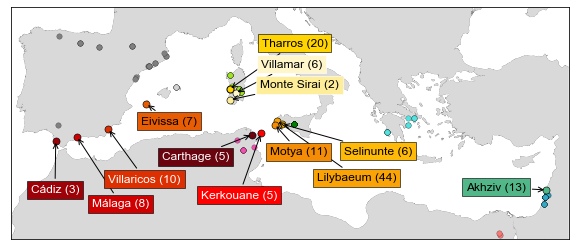

In [4]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plot_map_ax(df=df, df_c= df_context, 
            crs=[29.5, 45, -10, 37], 
            fs_label=12, s_c=30, s=50, lw=1.0, lw_c=0.2,
            savepath="") # ./figures/maps/ia_med.pdf
plt.show()

# Plot new North Africa Sample

In [7]:
def set_lat_lon_df(df=[], col="loc", label="", lat=0, lon=0):
    """Overwrite all rows with label in col, setting new lat and lon
    Return update df"""
    idx = df[col]==label
    df.loc[idx,"lat"] = lat
    df.loc[idx,"lon"] = lon
    print(f"Overwrote {np.sum(idx)} {label} with manual lat/lon")

In [8]:
df_nafr = pd.read_csv("./data/plot_nafr.v51.1.tsv", sep="\t")
df_meta = pd.read_csv("/n/groups/reich/hringbauer/Data/v51.1.anno.csv", sep=",")
df1 = pd.merge(df_nafr, df_meta[["iid", "lat", "lon"]], on="iid")
set_lat_lon_df(df1, label="Kelif el Boroud", lat=32.504540, lon=-7.192650)
set_lat_lon_df(df1, label="Ifri n'Amr or Moussa", lat=33.884220, lon=-5.923560)

Overwrote 3 Kelif el Boroud with manual lat/lon
Overwrote 3 Ifri n'Amr or Moussa with manual lat/lon


In [ ]:
df1

Saved to ./figures/nafr/map_sample.pdf


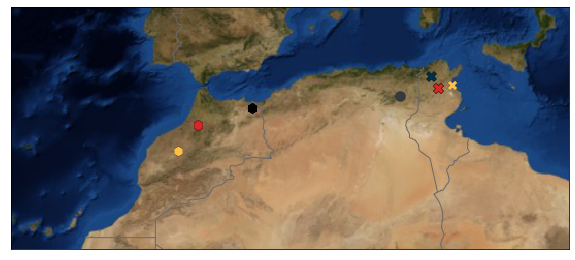

In [9]:
res="h"
crs=[27, 40, -18, 18]
lw_coast=1
states=False
countries=True
savepath="./figures/nafr/map_sample.pdf"
ec, lw_c = "k", 0.2
s_c= 100

plt.figure(figsize=(10,5))
ax = plt.gca()

m = Basemap(projection='merc', llcrnrlat=crs[0], urcrnrlat=crs[1],\
                llcrnrlon=crs[2], urcrnrlon=crs[3], resolution=res, ax=ax)  # mill
#col_cont = "#d9d9d9", col_lake = "#d9d9d9"
#m.fillcontinents(color=col_cont, zorder=0, lake_color=col_lake)
#m.etopo(scale=0.5, alpha=0.4)  # Topological Map
m.bluemarble()
m.drawcoastlines(color='gray', zorder=0, linewidth=lw_coast)
if countries:
    m.drawcountries(color="dimgray", linewidth=1)
if states:
    m.drawstates()
    
if len(df1)>0:
    for _, row in df1.iterrows():
        lat, lon, c, marker = row["lat"], row["lon"], row["color"], row["symbol"]
        x,y = m(lon, lat)
        ax.scatter(x, y, c=c, ec=ec, lw=lw_c, s=s_c, marker=marker, zorder=1)


if len(savepath)>0:
    plt.savefig(savepath, bbox_inches = 'tight', pad_inches = 0)
    print(f"Saved to {savepath}")    

plt.show()

# Area 51

In [ ]:
df, df_c=[], crs=[30, 60, -10, 40], s=40, s_c=40, 
                lw=0.2, lw_c=0.2, ec="k", 
                col_cont = "#d9d9d9", col_lake = "#d9d9d9", 
                lw_coast=0.5, res="i",
                fs_label=14, figsize=(12,11), states=False, countries=False, ew=0.5,
                hspace=0.02, fs=18, 
                show=True, savepath=""

In [53]:
df_context[df_context["clst"].str.contains("Alg")]

,iid,pc1,pc2,pc3,pc4,pop,Master ID,clst,loc,n_cov_snp,mean_cov,sex,age,contact,lat,lon,color,label
135,I12433,-0.042262,-0.050145,-0.045415,-0.044939,include,I12433,Algeria_IA,"Aurès, Constantine, Khenchela Cave",756415.0,0.630346,F,2752.0,"Pinhasi, Ron",35.427657,7.145072,#343a40,Algeria IA
